## Intro

This is an example notebook of how I would approach an image classification task by using Tensorflow.

The dataset is the "malaria" dataset, which contains 27558 images of blood cells. About half of the images are parasitized with malaria, and the purpose of the example is to build a deep neural network model that can tell the difference between the parasitized and healthy cells.

**Purpose:** showcase skills with Tensorflow for image classification.

**Inputs:**  

### Data preparation
First, let's use Tensorflow_datasets and download the "malaria"-dataset.

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
from tensorflow.python.keras.utils.layer_utils import count_params
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from copy import copy

In [2]:
# Let's split the data into 80% train, 10% validation and 10% test sets.

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'malaria',
#    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [3]:
print("Image set properties:")
print(raw_train)
print(raw_validation)
print(raw_test)

print("Train set size: ", len(list(raw_train)))
print("Validation set size: ", len(list(raw_validation)))
print("Test set size: ", len(list(raw_test)))

Image set properties:
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Train set size:  19291
Validation set size:  5511
Test set size:  2756


The shape of the datasets is (None, None, 3), where the first two values are the width and height, but since the images have varying shapes and sizes it shows "None". The last value is the color channel, which means we have three colors, i.e. a color image. After resizing and scaling all the images will be (128, 128, 3) in shape.

The 27558 images are split into 22046 training images, 2756 validation images and 2756 test images.

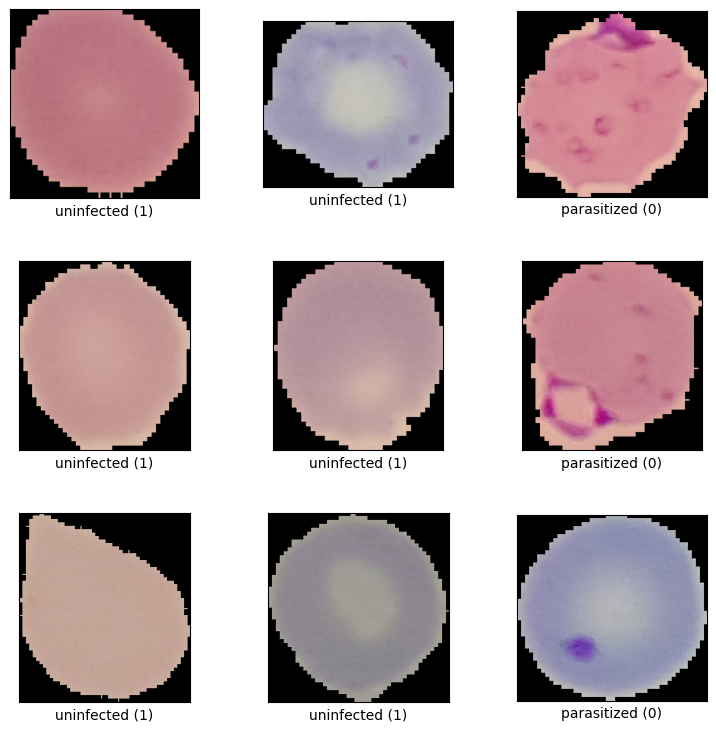

In [4]:
# Plot some of the images to see differences between uninfected and parasitized cells
vis = tfds.visualization.show_examples(raw_train, metadata)

We can see that the images can be of different color. The parasitized, or infected, cell has red blobs inside it, but as we can see from the second image an uninfected cell can also have some blobs. This can make the process little more challenging, especially for human eye.

### Data augmentation

Let's add data augmentation. The augmentation randomly changes the brightness and contrast, adds padding and then crops it back (shifts the image around) and flips the image horizontally or vertically. This is done to add variation in the training dataset. The augmentation is not added to the validation or testing sets.

In the end we need to change the pixel values to float and use the Mobilenet preprocessing that scales the pixel values down to between -1 and 1.

In [5]:
NEW_SIZE = 128

def augment(image, label):
    image = tf.image.resize_with_crop_or_pad(image, NEW_SIZE+10, NEW_SIZE+10) 
    image = tf.image.random_crop(image, size=[NEW_SIZE, NEW_SIZE, 3]) 
    image = tf.image.random_brightness(image, max_delta=0.2) 
    image = tf.image.random_contrast(image,0.8,1.2) 
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image, label

In [6]:
# Augment the training set
train = raw_train.map(augment)

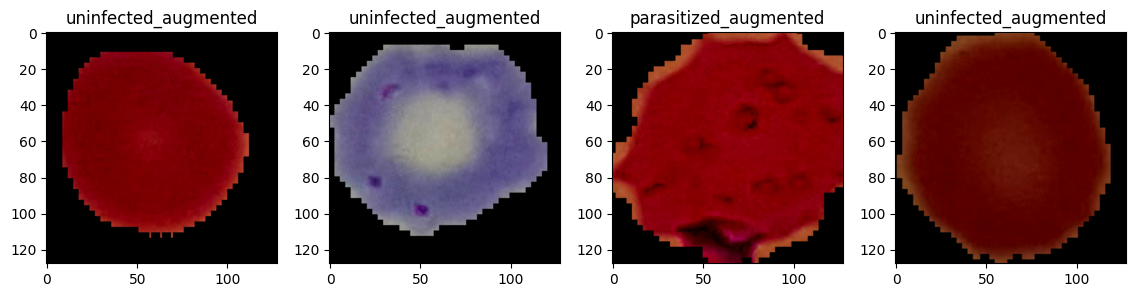

In [7]:
# Plotting the first three images but with augmentation
label_name = metadata.features['label'].int2str
fig, ax = plt.subplots(1,4,figsize=(14,3))
for i, (image, label) in enumerate(train.take(4)):
    ax[i].imshow(image)
    ax[i].set_title(label_name(label) + "_augmented")

Let's format the validation and test images. Change values to floats, resize the images to 128x128, apply Mobilenet preprocessing.

In [8]:
def format(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (NEW_SIZE, NEW_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image, label

In [9]:
validation = raw_validation.map(format)
test = raw_test.map(format)

Let's check couple images and their maximum and minimum pixel values. They should stay between -1 and 1. 

In [10]:
for image, label in train.take(2):
    tf.print("min: ", tf.reduce_min(image), " max: ", tf.reduce_max(image))

min:  -0.929411769  max:  0.772549033
min:  -0.921568632  max:  0.105882406


Check that the train set is of size (128, 128, 3)

In [11]:
print(train)

<MapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


Next let's shuffle and batch the datasets. We also add prefetch to speed up the batch loading process.

In [12]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

We should get batches the size of dataset_size/batch_size = 22048/64 = 345. Similarly to validation and train batches.

In [13]:
print(len(list(train_batches)))
print(len(list(validation_batches)))
print(len(list(test_batches)))

302
87
44


Check that all the dimensions are proper. In each batch we should have 64 image batches, with the 128x128 images and 3 color channels.

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([64, 128, 128, 3])

### Setting up MobileNet

Let's use a pre-trained model called MobileNet V2. This dataset has been trained with over 1.4 million images and over 1000 classes. These don't include our malaria dataset, so we need some more training. Using a pre-trained model means we don't need to spend days training the base layers, but instead we can use the ones from the pre-trained model.

We only load the base of the model, and not the top part that's specialised in the classification. This way we can train our own top layer that will be trained to classify the malaria dataset. We also use pre-trained weights trained with ImageNet.

In [15]:
IMG_SHAPE = (NEW_SIZE, NEW_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In order not to train the base model, we will freeze the base. We only build our own classification layer on top of this and train it. To freeze the base, we set the whole base model untrainable.

In [16]:
base_model.trainable = False

We can check the model's stucture and verify there should be no trainable paramenters.

In [17]:
trainable_count = count_params(base_model.trainable_weights)
non_trainable_count = count_params(base_model.non_trainable_weights)
print("Trainable parameters:", trainable_count)
print("Non trainable parameters:", non_trainable_count)

Trainable parameters: 0
Non trainable parameters: 2257984


In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 16, 16, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 16, 16, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 16, 16, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 16, 16, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 8, 8, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 8, 8, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 8, 8, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 8, 8, 96)    384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 8, 8, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 8, 8, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 8, 8, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 4, 4, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 4, 4, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 4, 4, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 4, 4, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

From the last layer we can see that it outputs a (None, 4, 4, 1280) tensor. First value is the batch size, rest means a 4x4 matrix with 1280 channels.

We want to reduce this to an output that tells us whether the image is infected or uninfected. With a sigmoid-activation function this means a decimal value between 0 and 1 from the dense layer, which can be rounded to 2 output values. Before this we want a single vector. We can use GlobalAveragePooling2D that takes the global average of those 4x4 matrices, resulting in a single 1280-long vector. Let's also add a 1280/4=360 dense layer in the middle. So our final trainable model looks like this:

In [19]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(360,activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Activation('sigmoid')
])

Let's compile the model with an Adam-optimizer, BinaryCrossentropy loss function and make it use accuracy as the metric.

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 360)               461160    
                                                                 
 dense_1 (Dense)             (None, 1)                 361       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,719,505
Trainable params: 461,521
Non-tr

We can see that our model looks as it should. Now we have 461,521 trainable parameters.

Let's check our loss and accuracy without any training.

In [22]:
loss0, accuracy0 = model.evaluate(validation_batches, steps = 20)

20/20 [==============================] - 6s 24ms/step - loss: 0.9401 - accuracy: 0.5305


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.94
initial accuracy: 0.53


The initial accuracy is about 50%, meaning a random choice, because the top layers haven't been trained yet.

Before training we want to save our model at checkpoints. This way later we can just load the saved file and continue training without having to train everything again. We only want to save the best model, and only the weights

In [24]:
cp_file_name ="checkpoints/cp.hdf5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    cp_file_name, save_weights_only=True, verbose=1, save_best_only=True)

In [25]:
# Clear the Tensorflow backend session just in case
tf.keras.backend.clear_session() 

### Training the basic model

First, let's just train the model for 20 epochs and see how it performs.

In [ ]:
# Set random seed for reproductible results
tf.random.set_seed(1)

# Train for 20 epochs at first
history1 = model.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches,
                    callbacks = [cp_callback])

Epoch 1/20
300/302 [============================>.] - ETA: 0s - loss: 0.2780 - accuracy: 0.8839
Epoch 1: val_loss improved from inf to 0.22426, saving model to checkpoints\cp.hdf5
302/302 [==============================] - 25s 72ms/step - loss: 0.2780 - accuracy: 0.8840 - val_loss: 0.2243 - val_accuracy: 0.9185
Epoch 2/20
 11/302 [>.............................] - ETA: 18s - loss: 0.2063 - accuracy: 0.9304

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', marker = '*')
plt.plot(val_acc, label='Validation Accuracy', marker = '*')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker = '*')
plt.plot(val_loss, label='Validation Loss', marker = '*')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_batches)

The model starts to increase in accuracy, but the validation accuracy seems to stabilize around 0.93 quite early already. The evaluation test accuracy is about 93% indeed.

### Fine-tuning the basic model

To increase the performance, let's start to open the layers in the base model and continue training. We do this as follows: For the next 40 epochs the script opens 1 layer in the base model every 5 epochs. In the end it has opened and trained 8 layers from the total of 154 layers.

In [ ]:
len(base_model.layers)

In [ ]:
history2 = copy(history1)
    
# The tuning value is the amount of layers to open. Starts from max 154
tuning_value = len(base_model.layers)

# Train until 60 epochs, every 5 epochs open 1 more layer
for i in range(24,61,5):
    # Set the base model to be trainable
    base_model.trainable = True

    # Open 1 more layers in every loop
    tuning_value -= 1

    # Set those new layers trainable
    fine_tune_at = tuning_value
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable =  False

    # Compile model again due to the change in model structure
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

    # The amount of epochs to train is i+1
    total_epochs = i+1

    # Train starting after last epoch until total epochs
    history2 = model.fit(train_batches,
                        epochs=total_epochs,
                        initial_epoch = history2.epoch[-1]+1,
                        validation_data=validation_batches,
                        callbacks = [cp_callback])

    # Every loop add the accuracy and loss values to the lists
    acc += history2.history['accuracy']
    val_acc += history2.history['val_accuracy']

    loss += history2.history['loss']
    val_loss += history2.history['val_loss']

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.scatter(val_acc.index(max(val_acc)),max(val_acc),s=200,lw=1.8,edgecolors="r",facecolors="none",label="Best value")
plt.legend(loc='lower right')
    
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.scatter(val_loss.index(min(val_loss)),min(val_loss),s=200,lw=1.8,edgecolors="r",facecolors="none",label="Best value")
plt.legend(loc='upper right')
    
plt.show()

Opening more layers and training longer improved the results. Let's evaluate and see predictions.

In [ ]:
# Show the evaluation accuracy
model.evaluate(test_batches)[1]

In [ ]:
predictions = model.predict(test_batches)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
    
for i, (image, label) in enumerate(test.take(4)):
    ax[i].imshow(image)
    if (predictions[i]>=0.5):
        title = " Real label: " + label_name(label) + "\nPredicted: uninfected\n" + str(predictions[i])
    else: 
        title = " Real label: " + label_name(label) + "\nPredicted: parasitized\n" + str(predictions[i])
    ax[i].set_title(title)

The first four examples were correctly labeled.

In [ ]:
plt.hist(predictions)

Most predictions are confidently close to either 0 or 1.

In [ ]:
def plot_confusion_matrix(actual, predicted, labels):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    ax.set_title('Confusion matrix)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [ ]:
def get_actual_predicted_labels(dataset): 
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    # round the predictions to either 0 or 1
    predicted = tf.math.round(predicted)

    return actual, predicted

In [ ]:
labels = metadata.features['label'].names
actual, predicted = get_actual_predicted_labels(test_batches)
plot_confusion_matrix(actual, predicted, labels)

The confusion matrix also shows that most images were correctly labeled. Only about 190 images were mislabeled.

### Preventing overfitting

If the training accuracy keeps increasing, but the validation accuracy stays stable (or worse, starts to decrease), it might be because of overfitting. There are several ways of reducing overfitting, for example:
- L1 or L2 regularizations. These will set a penalty term to the weights.
- Dropout, which randomly drops some neurons from the network, making the model less dependent on single neurons.
- Batch normalization, which normalises the layer's values before passing it forward.

After testing all of these outside of this notebook, batch normalization seemed to result in the best accuracy. Let's try to train another model, but with BN added before the dense layers.

In [ ]:
base_model_bn = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model_bn.trainable = False

model_bn = tf.keras.Sequential([
  base_model_bn,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(360,activation='relu'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Activation('sigmoid')
])

model_bn.summary()

### Training the batch normaized model

In [ ]:
model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

cp_file_name ="checkpoints/cp_bn.hdf5"

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    cp_file_name, save_weights_only=True, verbose=1, save_best_only=True)

history_bn = model_bn.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches,
                    callbacks = [cp_callback])

In [ ]:
acc_bn = history_bn.history['accuracy']
val_acc_bn = history_bn.history['val_accuracy']

loss_bn = history_bn.history['loss']
val_loss_bn = history_bn.history['val_loss']

### Fine-tuning the batch normalized model

In [ ]:
history_bn2 = copy(history_bn)

tuning_value = len(base_model_bn.layers)

for i in range(24,61,5):
    # Set the base model to be trainable
    base_model_bn.trainable = True

    # Open 1 more layers in every loop
    tuning_value -= 1

    # Set those new layers trainable
    fine_tune_at = tuning_value
    for layer in base_model_bn.layers[:fine_tune_at]:
        layer.trainable =  False

    model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00004),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy']) 

    total_epochs = i+1

    history_bn2 = model_bn.fit(train_batches,
                        epochs=total_epochs,
                        initial_epoch = history_bn2.epoch[-1]+1,
                        validation_data=validation_batches,
                        callbacks = [cp_callback])

    acc_bn += history_bn2.history['accuracy']
    val_acc_bn += history_bn2.history['val_accuracy']

    loss_bn += history_bn2.history['loss']
    val_loss_bn += history_bn2.history['val_loss']

In [ ]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', linestyle='--',c="navy")
plt.plot(val_acc, label='Validation Accuracy', linestyle='--',c="green")
plt.plot(acc_bn, label='Training Accuracy with BN',c="blue")
plt.plot(val_acc_bn, label='Validation Accuracy with BN',c="forestgreen")
plt.ylim([min(plt.ylim()),1])
plt.scatter(val_acc_bn.index(max(val_acc_bn)),max(val_acc_bn),s=200,lw=1.8,edgecolors="r",facecolors="none",label="Best value")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss',linestyle='--',c="navy")
plt.plot(val_loss, label='Validation Loss',linestyle='--',c="green")
plt.plot(loss_bn, label='Training Loss with BN',c="blue")
plt.plot(val_loss_bn, label='Validation Loss with BN',c="forestgreen")
plt.ylim([0, max(plt.ylim())])
plt.scatter(val_loss_bn.index(min(val_loss_bn)),min(val_loss_bn),s=200,lw=1.8,edgecolors="r",facecolors="none",label="Best value")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model_bn.predict(test_batches)

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(15,4))
    
for i, (image, label) in enumerate(test.take(4)):
    ax[i].imshow(image)
    if (predictions[i]>=0.5):
        title = " Real label: " + label_name(label) + "\nPredicted: uninfected\n" + str(predictions[i])
    else: 
        title = " Real label: " + label_name(label) + "\nPredicted: parasitized\n" + str(predictions[i])
    ax[i].set_title(title)

In [ ]:
plt.hist(predictions)

In [ ]:
labels = metadata.features['label'].names
actual, predicted = get_actual_predicted_labels(test_batches)
plot_confusion_matrix(actual, predicted, labels, 'training')

In [ ]:
# Show the evaluation accuracy
model_bn.evaluate(test_batches)[1]

The batch-normalized model performs slightly better, resulting in 94% accuracy. 

The histogram of the prediction shows that most test images were quite confidently categorized at either 0 or 1, but there are some values closer to the center where there might be mislabelings. 

The confusion matrix proves this. While most parasitized and uninfected images were correctly labeled, there were 37 parasitized images that were labeled as uninfected, and 218 uninfected images that were labeled as parasitized. Since the model gives a decimal value between 0 and 1, we can tune the threshold of labeling the result. Now it was simply 0.5, but if we want the model to be more sensitive to give "parasetized"-labels, we can lower the threshold. In real life applications this is a desired outcome, since it is better that more unifencted cells are checked since the model labeled then infected, than if many infected cells go unnoticed since the model labeled then uninfencted.